In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [165]:
import pandas as pd


df = pd.read_csv(r'./mesra.txt', names=['mesra'], header=None)
df['beyt index'] = df.index // 2
df = df.groupby(['beyt index']).agg({'mesra': ' '.join})
df = df.rename(columns={'mesra':'beyt'})

In [166]:
df

,beyt
beyt index,
0,الا یا ایها الساقی ادر کاسا و ناولها که عشق آسان نمود اول ولی افتاد مشکل‌ها
1,به بوی نافه‌ای کاخر صبا زان طره بگشاید ز تاب جعد مشکینش چه خون افتاد در دل‌ها
2,مرا در منزل جانان چه امن عیش چون هر دم جرس فریاد می‌دارد که بربندید محمل‌ها
3,به می سجاده رنگین کن گرت پیر مغان گوید که سالک بی‌خبر نبود ز راه و رسم منزل‌ها
4,شب تاریک و بیم موج و گردابی چنین هایل کجا دانند حال ما سبکباران ساحل‌ها
...,...
164849,از من بگو بدان مه خرگاهی آه و فغان من به قلک برشد
164850,سنگین دلت نیافته آگاهی با آهنین دل تو چه داند کرد؟
164851,آه شب و فغان سحرگاهی ای همنشین بیهوده گو تا چند


In [167]:
# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim as gensimvis  # don't skip this

# NLP stuff
import string
from hazm import *
import codecs

# Plotting tools
# from bokeh.plotting import figure, output_file, show
# from bokeh.models import Label
# from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
# from sklearn.manifold import TSNE
from pprint import pprint

In [168]:
normalizer = Normalizer()
stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.dat','r','utf-8').readlines()]
lemmatizer = Lemmatizer()

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]
    return tokens

In [169]:
data_words = df['beyt'].apply(preprocess).tolist()

In [170]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=30) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [171]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [172]:
data_preprocessed = make_bigrams(data_words)
print(*data_preprocessed[:20], sep='\n')
print('doc len: ', len(data_preprocessed))

['الا', 'یا', 'ای', 'الساق', 'ادر', 'کاسا', 'و', 'ناولها', 'که', 'عشق', 'آسان', 'نمود', 'اول', 'ولی', 'افتاد#افت', 'مشکل']
['به', 'بو', 'نافه', 'کاخر', 'صبا', 'زان', 'طره', 'گشود#گشا', 'ز', 'تاب', 'جعد', 'مشکین', 'چه', 'خون', 'افتاد#افت', 'در', 'دل']
['مرا', 'در', 'منزل', 'جانان', 'چه', 'امن', 'عیش', 'چون', 'هر', 'دم', 'جرس', 'فریاد', 'داشت#دار', 'که', 'بربندید', 'محمل']
['به', 'می', 'سجاده', 'رنگین', 'کن', 'گر', 'پیر_مغان', 'گفت#گو', 'که', 'سالک', 'بی\u200cخبر', 'بود#باش', 'ز', 'راه', 'و', 'رسم', 'منزل']
['شب_تاریک', 'و', 'بیم', 'موج', 'و', 'گرداب', 'چنین', 'هایل', 'کجا', 'دانست#دان', 'حال', 'ما', 'سبکباران', 'ساحل']
['همه', 'کاشت#کار', 'ز', 'خود', 'کام', 'به', 'بدنام', 'کشید#کش', 'آخر', 'نهان', 'کی', 'ماند#مان', 'آن', 'راز', 'کز', 'او', 'ساخت#ساز', 'محفل']
['حضور', 'گر', 'همی\u200cخواهی', 'از', 'او', 'غایب', 'مشو', 'حافظ', 'متی', 'ما', 'تلق', 'من', 'تهوی', 'دع', 'الدنیا', 'و', 'اهملها']
['صلاح', 'کار', 'کجا', 'و', 'من', 'خراب', 'کجا', 'دید#بین', 'تفاوت', 'ره', 'کز', 'کجاست', 'تا', 'ب

In [173]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_preprocessed)
id2word.filter_extremes(no_below=50, no_above=0.3, keep_n=4000)

# the preprocessed and lemmatized documents themselves
texts = data_preprocessed

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[11])

[(56, 1), (59, 2), (77, 1), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1)]


In [174]:
# Build LDA model
from gensim.models.ldamulticore import LdaMulticore


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Going to evaluate topic size:",num_topics)
        model =  LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=100,
                         passes=4,
                         per_word_topics=False)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))
    return model_list, coherence_values, perplexity_values

In [175]:
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

In [176]:
limit=602; start=1; step=100;

model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_preprocessed, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

Going to evaluate topic size: 1
Going to evaluate topic size: 101
Going to evaluate topic size: 201
Going to evaluate topic size: 301
Going to evaluate topic size: 401
Going to evaluate topic size: 501
Going to evaluate topic size: 601


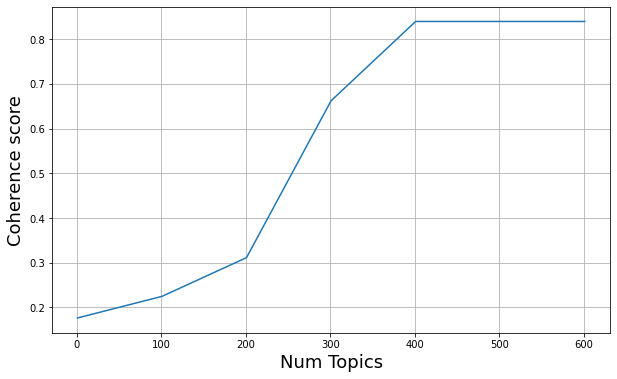

In [177]:
# Graph coherence values vs number of topics
x = range(start, limit, step)
fig = plt.figure(figsize=(10,6))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics", fontsize=18)
plt.ylabel("Coherence score", fontsize=18)
plt.grid()
fig.savefig('./figures/coherence_vs_numtopics.png')

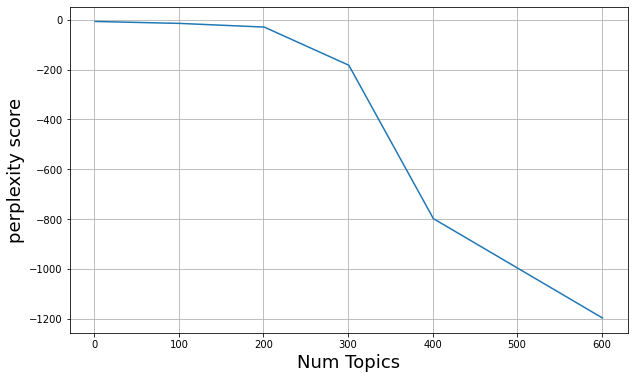

In [178]:
fig = plt.figure(figsize=(10,6))
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics", fontsize=18)
plt.ylabel("perplexity score", fontsize=18)
plt.grid()
fig.savefig('./figures/perplexity_vs_numtopics.png')

In [179]:
from gensim.models.ldamulticore import LdaMulticore

lda_model =  LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=200,
                         random_state=100,
                         chunksize=100,
                         passes=50,
                         per_word_topics=False)

In [180]:
lda_model.save('./results/lda_model')

In [181]:
for i in range(lda_model.num_topics):
    print(lda_model.top_topics(corpus=corpus)[i])
    print('-'*50)

([(0.15039875, 'آخر'), (0.12573957, 'آه'), (0.09381816, 'از'), (0.092182145, 'دوش'), (0.08265742, 'بزم'), (0.079815835, 'شنید#شنو'), (0.060995083, 'دود'), (0.04741576, 'به'), (0.036797002, 'کرد#کن'), (0.031070696, 'بر'), (0.02821198, 'این'), (0.027944071, 'دل'), (0.026218109, 'ندامت'), (0.023023915, 'که'), (0.022359904, 'در'), (0.02005052, 'گذر'), (0.014240211, 'چه'), (0.011786445, '#است'), (0.011564763, 'و'), (0.0064958995, 'آن')], -2.832843962234711)
--------------------------------------------------
([(0.2348085, 'گرد'), (0.15858738, 'تن'), (0.080776446, 'گره'), (0.05992883, 'نوشت#نویس'), (0.05677861, 'در'), (0.053538747, 'به'), (0.04767173, 'بر'), (0.041917756, 'دل'), (0.035566457, 'من'), (0.032328334, 'تخم'), (0.030133624, 'سلسله'), (0.027761316, 'که'), (0.022168713, 'ز'), (0.018176079, 'تو'), (0.01694419, 'این'), (0.014794138, 'چه'), (0.013365213, 'کرد#کن'), (0.010782595, 'از'), (0.009807774, 'آن'), (0.009229268, '#است')], -2.840555123003074)
-------------------------------------

([(0.1785007, 'من'), (0.11958308, 'عرض'), (0.07394649, 'و'), (0.07204558, 'جفا'), (0.05607458, 'تو'), (0.055895608, 'از'), (0.04240646, 'که'), (0.04160663, 'به'), (0.03597297, 'رسم'), (0.03197864, 'دل'), (0.03136431, 'مده'), (0.031023059, 'کرد#کن'), (0.02999859, 'بر'), (0.026856644, 'ز'), (0.025145018, '#است'), (0.02455419, 'افتادگی'), (0.02064108, 'چه'), (0.018375995, 'مال'), (0.017736254, 'مغرور'), (0.017407455, 'در')], -4.145238813617118)
--------------------------------------------------
([(0.114543684, 'جوش'), (0.09069881, 'پری'), (0.062552236, 'و'), (0.061508812, 'از'), (0.051615108, 'شاد'), (0.05080186, 'شاید'), (0.050596144, 'بتان'), (0.047191378, 'که'), (0.041445028, 'به'), (0.040681195, 'نشاط'), (0.037087772, 'دل'), (0.03688402, 'ز'), (0.027318442, 'حور'), (0.024856506, '#است'), (0.0230096, 'در'), (0.022265326, 'من'), (0.021606825, 'کرد#کن'), (0.019681403, 'درست'), (0.019452782, 'آن'), (0.01926087, 'را')], -4.167635020533622)
--------------------------------------------------

([(0.16829593, 'گشود#گشا'), (0.087267205, 'وجود'), (0.075501256, 'جو'), (0.067848824, 'دهر'), (0.06295161, 'در'), (0.05370541, 'و'), (0.047597885, 'سراپا'), (0.03818316, 'از'), (0.038045455, 'وصف'), (0.03689596, 'به'), (0.03386066, 'ز'), (0.03263149, '#است'), (0.031865146, 'عید'), (0.029959697, 'که'), (0.026738763, 'تو'), (0.024371957, 'را'), (0.024209274, 'آب_حیات'), (0.02211294, 'خواست'), (0.019011993, 'آن'), (0.018956173, 'این')], -4.6402611016921265)
--------------------------------------------------
([(0.2414752, 'سخن'), (0.097545415, 'آغوش'), (0.09670323, 'تسلیم'), (0.08613262, 'از'), (0.07624554, 'در'), (0.05435739, 'جسم'), (0.048822146, 'فهم'), (0.03766045, 'جرعه'), (0.036429938, 'مقصود'), (0.03318721, 'میکده'), (0.027738461, 'ز'), (0.024759097, 'کرد#کن'), (0.02353143, 'دادن'), (0.023141172, 'به'), (0.017095648, 'من'), (0.015932674, 'خشت'), (0.013791416, 'که'), (0.013522554, 'تو'), (0.01278807, 'بر'), (0.012684254, 'و')], -4.703977436392819)
------------------------------------

([(0.13961263, 'نیز'), (0.115365244, 'انجمن'), (0.07648247, 'شکسته'), (0.07238261, 'پشت'), (0.042538792, 'این'), (0.039130364, 'مدام'), (0.036557686, 'دل'), (0.03640224, 'بر'), (0.033217583, '#است'), (0.032699246, 'و'), (0.030222753, 'مور'), (0.027745016, 'تو'), (0.02662914, 'سلیمان'), (0.024182452, 'را'), (0.023874829, 'کرد#کن'), (0.023756212, 'به'), (0.023025624, 'ز'), (0.022608425, 'قوم'), (0.02246155, 'معرفت'), (0.021844085, 'من')], -5.105069100459909)
--------------------------------------------------
([(0.1409702, 'شیرین'), (0.09245186, 'اسیر'), (0.064402066, 'تنها'), (0.06265808, 'خوان'), (0.059856083, 'از'), (0.05207394, 'نقطه'), (0.051501315, 'بیداد'), (0.048352182, 'تو'), (0.046560198, 'و'), (0.045041848, 'فرمان'), (0.042924985, 'من'), (0.03455157, 'بر'), (0.02924814, 'به'), (0.024459226, 'رونق'), (0.022444753, 'که'), (0.02041372, 'صهبا'), (0.01937862, 'آن'), (0.017016536, '#است'), (0.016214477, 'چه'), (0.014977815, 'را')], -5.118866632671461)
--------------------------------

([(0.09467933, 'پس'), (0.06832204, 'از'), (0.061605208, 'چاک'), (0.04797688, 'به'), (0.04661002, 'نو'), (0.04092381, 'را'), (0.040325496, 'جهد'), (0.040222175, 'پرداخت#پرداز'), (0.037684318, 'و'), (0.03554308, 'بودن'), (0.034205556, 'پیرهن'), (0.031307474, 'من'), (0.030212222, 'ز'), (0.026901975, 'کرد#کن'), (0.024878906, 'تو'), (0.024135826, 'مستانه'), (0.023764, 'آشفته'), (0.022096429, '#است'), (0.021619234, 'سفید'), (0.020390278, 'این')], -5.600951228132972)
--------------------------------------------------
([(0.32096478, 'درد'), (0.12594666, 'خو'), (0.08297151, 'از'), (0.05624056, 'دل'), (0.044216283, 'درمان'), (0.043067202, 'که'), (0.042835906, 'من'), (0.03544924, 'بعد'), (0.034717724, 'و'), (0.03303146, 'مقام'), (0.032694362, 'کرد#کن'), (0.031587295, 'به'), (0.027271997, 'تو'), (0.026820274, 'رقیب'), (0.021522583, 'این'), (0.017586991, 'رضا'), (0.013135684, 'آن'), (0.008442721, 'مشتری'), (4.6572237e-07, 'گزید'), (4.6572237e-07, 'قابل')], -5.710584828568534)
----------------------

([(0.1395507, 'پنهان'), (0.08531454, 'محمل'), (0.06150842, 'جامه'), (0.061236233, 'فرق'), (0.053945817, 'دستم'), (0.052446377, 'ز'), (0.049779277, 'چگونه'), (0.046931107, 'خضر'), (0.04469936, 'کرد#کن'), (0.04419521, 'از'), (0.042669065, 'قبا'), (0.0382913, 'که'), (0.035974044, 'بر'), (0.03197925, 'من'), (0.029323783, 'تو'), (0.022475855, 'به'), (0.022039711, 'نظم'), (0.018109081, 'می\u200cچکد'), (0.018026978, 'سماع'), (0.016300699, 'را')], -6.227528909710428)
--------------------------------------------------
([(0.17454758, 'نقد'), (0.08802812, 'سپر'), (0.079210065, 'سوار'), (0.07593971, 'رکاب'), (0.07435152, 'منع'), (0.067350835, 'شکن'), (0.056766577, 'بیار'), (0.051051464, 'از'), (0.04062198, 'را'), (0.034500487, 'بر'), (0.03340817, 'کرد#کن'), (0.030906664, 'به'), (0.030098712, 'و'), (0.019889023, 'این'), (0.019667832, 'ولایت'), (0.019050322, 'من'), (0.01820642, 'خط_سبز'), (0.016303739, 'عدو'), (0.013620997, 'آن'), (0.010105843, 'ز')], -6.312249690290689)
----------------------------

([(0.59082866, 'خون'), (0.06782923, 'کجاست'), (0.06642188, 'شیر'), (0.06259509, 'فدا'), (0.04992036, 'کرد#کن'), (0.03691675, 'از'), (0.027507352, 'گرفته'), (0.021604639, 'نازنین'), (0.016936209, 'مذهب'), (0.012266935, 'مادر'), (0.01038055, 'نکهت'), (0.008196801, 'پسر'), (0.0066732336, '#است'), (0.005507142, 'که'), (0.004906207, 'این'), (0.00474558, 'تو'), (0.004432596, 'چه'), (7.2497323e-07, 'قابل'), (7.2497323e-07, 'مرجان'), (7.2497323e-07, 'فن')], -7.107774183485914)
--------------------------------------------------
([(0.1780691, 'کیست'), (0.10487709, 'شهر'), (0.10121202, 'خسته'), (0.09967061, 'فغان'), (0.07368674, 'که'), (0.07149803, 'دل'), (0.06629964, 'کدام'), (0.056567617, 'در'), (0.051680077, 'من'), (0.04858967, 'و'), (0.034174558, 'ز'), (0.033831235, 'سرگشته'), (0.0333403, 'این'), (0.030891933, 'به'), (0.008104418, '#است'), (0.004260434, 'اندرون'), (1.0094664e-06, 'حیوان'), (1.0094664e-06, 'بنمای'), (1.0094664e-06, 'مرجان'), (1.0094664e-06, 'قابل')], -7.14728324542123)
-------

([(0.16158256, 'حباب'), (0.0663791, 'فقر'), (0.052202184, 'و'), (0.045216743, 'تمکین'), (0.04477143, 'گشاد'), (0.039477736, 'به'), (0.034750495, 'در'), (0.0341621, 'کلاه'), (0.03328986, 'صف'), (0.03282403, '#است'), (0.032089688, 'از'), (0.029756011, 'را'), (0.025464915, 'ز'), (0.024653008, 'سبب'), (0.021890754, 'کرشمه'), (0.021225344, 'جاوید'), (0.01940734, 'برده'), (0.019103104, 'چه'), (0.018549368, 'عرش'), (0.017923772, 'وار')], -7.706217682415938)
--------------------------------------------------
([(0.124589965, 'چین'), (0.08504804, 'فردا'), (0.075423144, 'حقیقت'), (0.07497715, 'و'), (0.05622281, 'بهشت'), (0.05179632, 'در'), (0.04645074, 'زده'), (0.045025826, 'استغنا'), (0.04213208, 'از'), (0.029674483, 'بره'), (0.027363747, 'بر'), (0.026197981, 'که'), (0.024535853, 'دان'), (0.024461668, 'پدید'), (0.023705127, 'ز'), (0.022006523, 'ببینید'), (0.019010404, 'مجاز'), (0.017840542, 'به'), (0.017429117, 'کرد#کن'), (0.01598481, 'پاسبان')], -7.717653061932721)
-----------------------------

([(0.1557527, 'زاهد'), (0.12505154, 'و'), (0.0952191, 'بازی'), (0.09393589, 'بنیاد'), (0.086501844, 'معشوق'), (0.083521366, 'حجاب'), (0.056939103, 'از'), (0.04317377, '#است'), (0.04034867, 'برخیز'), (0.03886889, 'زنهار'), (0.02877991, 'خودی'), (0.028767485, 'که'), (0.026619041, 'کرد#کن'), (0.02408479, 'صومعه'), (0.01623323, 'آن'), (0.016138988, 'این'), (0.012649824, 'مکر'), (0.008374111, 'دیر_مغان'), (0.008267575, 'حقه'), (0.0053210002, 'حقا')], -8.414407213964328)
--------------------------------------------------
([(0.24652301, 'و'), (0.16579954, 'ملک'), (0.1467418, 'دین'), (0.116615355, 'عین'), (0.08337176, 'آدم'), (0.08153593, 'کفر'), (0.061836123, 'در'), (0.037252534, 'دل'), (0.020487117, 'از'), (0.010638078, 'کرد#کن'), (0.00840618, 'اش'), (0.008064299, 'این'), (0.0058146487, 'بر'), (0.0038761657, 'آن'), (9.4387013e-07, 'تنگنا'), (9.4387013e-07, 'حیرتم'), (9.4387013e-07, 'بباید'), (9.4387013e-07, 'عطا'), (9.4387013e-07, 'حیوان'), (9.4387013e-07, 'سفید')], -8.423972383493743)
-----

([(0.50085497, 'گرفت#گیر'), (0.107232966, 'خنده'), (0.08266623, 'که'), (0.06560309, 'ز'), (0.056721777, 'مفت'), (0.054581363, 'جور'), (0.036874786, 'حذر'), (0.026044024, 'آن'), (0.022145644, 'وان'), (0.0171059, 'کرد#کن'), (0.015315768, 'تو'), (0.012677161, 'چه'), (6.7591196e-07, 'چشمه_خورشید'), (6.7591196e-07, 'فن'), (6.7591196e-07, 'حیوان'), (6.7591196e-07, 'قابل'), (6.7591196e-07, 'بباید'), (6.7591196e-07, 'نقش_نگین'), (6.7591196e-07, 'مرجان'), (6.7591196e-07, 'تنگنا')], -10.25174605271668)
--------------------------------------------------
([(0.47174814, 'عشق'), (0.24737601, 'زد#زن'), (0.051234595, 'و'), (0.048297916, 'لطف'), (0.045485616, '#است'), (0.026864782, 'از'), (0.024704576, 'باخت#باز'), (0.023983594, 'لاف'), (0.020700913, 'کرد#کن'), (0.018992824, 'طمع'), (0.009682953, 'مبر'), (0.008499277, 'دلا'), (0.0016199795, 'چست'), (2.513314e-07, 'تنگنا'), (2.513314e-07, 'حیرتم'), (2.513314e-07, 'بباید'), (2.513314e-07, 'حیوان'), (2.513314e-07, 'قابل'), (2.513314e-07, 'مرجان'), (2.5133

([(0.256635, 'خدا'), (0.1443665, 'کردن'), (0.13511002, 'را'), (0.11079359, 'سلطان'), (0.08365701, 'به'), (0.06982456, 'خدمت'), (0.054401807, 'که'), (0.052512586, 'طریق'), (0.044774584, 'بندگی'), (0.02482448, 'و'), (0.020082274, 'رها_کن'), (9.367944e-07, 'قابل'), (9.367944e-07, 'تنگنا'), (9.367944e-07, 'حیرتم'), (9.367944e-07, 'کرانه'), (9.367944e-07, 'بباید'), (9.367944e-07, 'حیوان'), (9.367944e-07, 'ولیک'), (9.367944e-07, 'پایی'), (9.367944e-07, 'مرجان')], -11.648799519114384)
--------------------------------------------------
([(0.27498218, 'یا'), (0.25536603, 'زان'), (0.18112591, 'خبر'), (0.13898379, 'فروغ'), (0.05631692, 'عکس'), (0.0464625, 'من'), (0.02098143, 'و'), (0.008723327, 'این'), (0.008205964, 'نگارین'), (0.005217765, 'دلستان'), (0.0012162672, 'در'), (7.506225e-07, 'حیوان'), (7.506225e-07, 'حیرتم'), (7.506225e-07, 'سفید'), (7.506225e-07, 'تنگنا'), (7.506225e-07, 'کرانه'), (7.506225e-07, 'ولیک'), (7.506225e-07, 'مرجان'), (7.506225e-07, 'بباید'), (7.506225e-07, 'قابل')], -11.

([(0.42359638, 'جام'), (0.13888969, 'وز'), (0.13718332, 'بنده'), (0.10958121, 'رساند#رسان'), (0.081058174, 'برو'), (0.05561057, 'را'), (0.030282278, 'شیخ'), (0.011498017, '#است'), (0.009610682, 'مرید'), (8.345772e-07, 'کرانه'), (8.345772e-07, 'ولیک'), (8.345772e-07, 'سفید'), (8.345772e-07, 'نقش_نگین'), (8.345772e-07, 'پیشت'), (8.345772e-07, 'سرو_خرامان'), (8.345772e-07, 'آور'), (8.345772e-07, 'بباید'), (8.345772e-07, 'تنگنا'), (8.345772e-07, 'طفل'), (8.345772e-07, 'حیرتم')], -14.157564054087606)
--------------------------------------------------
([(0.32653475, 'کز'), (0.27095252, 'صبح'), (0.24354704, 'هوا'), (0.11982186, 'امروز'), (0.018513653, 'بانگ'), (0.008139523, 'خنک'), (0.0073834327, 'این'), (0.003388299, 'گنبد'), (5.332077e-07, 'ولیک'), (5.332077e-07, 'رهبر'), (5.332077e-07, 'مپسند'), (5.332077e-07, 'سفید'), (5.332077e-07, 'حیوان'), (5.332077e-07, 'بباید'), (5.332077e-07, 'گزید'), (5.332077e-07, 'حیرتم'), (5.332077e-07, 'تنگنا'), (5.332077e-07, 'کرانه'), (5.332077e-07, 'مرجان'),

([(0.00030940596, 'حیوان'), (0.00030940596, 'نمی\u200cباید'), (0.00030940596, 'مپسند'), (0.00030940596, 'رهبر'), (0.00030940596, 'نقش_نگین'), (0.00030940596, 'گزید'), (0.00030940596, 'قابل'), (0.00030940596, 'تست'), (0.00030940596, 'بباید'), (0.00030940596, 'حیرتم'), (0.00030940596, 'تنگنا'), (0.00030940596, 'کرانه'), (0.00030940596, 'ولیک'), (0.00030940596, 'طفل'), (0.00030940596, 'سفید'), (0.00030940596, 'پیشت'), (0.00030940596, 'سرو_خرامان'), (0.00030940596, 'مرجان'), (0.00030940596, 'دلیل'), (0.00030940596, 'چشمه_خورشید')], -18.47187532275684)
--------------------------------------------------
([(0.00030940596, 'حیوان'), (0.00030940596, 'نمی\u200cباید'), (0.00030940596, 'مپسند'), (0.00030940596, 'رهبر'), (0.00030940596, 'نقش_نگین'), (0.00030940596, 'گزید'), (0.00030940596, 'قابل'), (0.00030940596, 'تست'), (0.00030940596, 'بباید'), (0.00030940596, 'حیرتم'), (0.00030940596, 'تنگنا'), (0.00030940596, 'کرانه'), (0.00030940596, 'ولیک'), (0.00030940596, 'طفل'), (0.00030940596, 'سفید'), (

In [182]:
corpus_infered = lda_model[corpus]

In [183]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_preprocessed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -27.21
Coherence Score:  0.31


In [184]:
def calc_query_LDA_likelihood(top_stats, query):
    topic_probs = np.full((1,lda_model.num_topics), 0.0001)
    for topics, probs in top_stats:
        topic_probs[0, topics] = probs
    return np.exp(np.sum(np.log(topic_probs @ lda_model.expElogbeta[:,query])))


In [185]:
corpus_infered.save("./results/lda_inferred_corp")

In [186]:
id2word.save('./results/lda_dict')

In [187]:
from tqdm import tqdm

def search(q):
    text = word_tokenize(q)
    text = [normalizer.normalize(w) for w in text]
    text = [lemmatizer.lemmatize(w) for w in text]
    doc = id2word.doc2idx(text)
    doc = list(filter(lambda a: a != -1, doc))
    res = list(map(lambda x: calc_query_LDA_likelihood(x, doc), tqdm(corpus_infered)))
    res = np.array(res)
    return np.argsort(res)[::-1]

In [188]:
pq_d = search('شهریار زیر آفتاب خورشید ماهی خورد')

100%|██████████| 164854/164854 [01:20<00:00, 2046.31it/s]


In [189]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0)

df['beyt'][pq_d[:20]]

beyt index
97064     ماه من روشن شده از آفتاب بر سپهر جان چنین مه هست نیست                              
27412     سفری فتاد جان را به ولایت معانی که سپهر و ماه گوید که چنین سفر ندارم               
152825    دوسه‌گام آخر ازین‌گذر توگران قدم زن و پا سبک اگرت به منظر بی‌نشان دم همتی بکشد عنان
68128     اوحدی امسال اگر آهنگ رفتن می‌کند گو: سفر می‌کن، که من حیران آن ماهم دگر            
21850     هله برجه هله برجه که ز خورشید سفر به قدم از خانه به در نه همگان را به سفر بر       
131763    اگر به قدر عدس دیده‌اند دنیا را به احتیاط قدم زن‌که عافیت‌طلبان                    
43088     اگر چه سیل بنالد ز راه ناهموار قدم قدم بودش در سفر تماشایی                         
123339    زعجز شب پرهٔ آفتاب را چه ملامت ترا چه غم که بمیرد هزار همچو من از غم               
49553     در پرتو آفتاب رویت خورشید سپهر ذره کردار                                           
34710     ای آفتاب روی تو کرده هزیمت ماه را و آن ماه در راه آمده از هزم تو پا کوفته          
161593    اگر بر هم نهی چشمی و طومار نظر پیچی اگر

In [190]:
def get_precision_at_k_score(ground_truth, preds, k):
    ground_truth = set(ground_truth)
    preds = set(preds[:k])
    intersection = ground_truth.intersection(preds)
    return len(intersection) / min(k, len(ground_truth))

In [191]:
import pickle

In [192]:
ranks1 = pickle.load(open('./small_eval/eval_ranks1.pkl', 'rb'))
ranks2 = pickle.load(open('./small_eval/eval_ranks2.pkl', 'rb'))
queries1 = pickle.load(open('./small_eval/queries1.pkl', 'rb'))
queries2 = pickle.load(open('./small_eval/queries2.pkl', 'rb'))
ranks = ranks1 + ranks2
queries = queries1 + queries2

In [194]:
for i, q in enumerate(queries):
    prec+= get_precision_at_k_score(ranks[i], search(q), 100)
print(f"precision_at_k_score for k={k} is {prec/len(queries)}")

100%|██████████| 164854/164854 [01:20<00:00, 2046.86it/s]

precision_at_k_score for k=1 is 0.36372150786074675
